In [1]:
#Importing Libraries
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,TimeDistributed,Bidirectional,Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
#import the librearies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

In [3]:
import yfinance as yf
#data = yf.download("AAPL", start="2017-01-01", end="2017-04-30")
#show the data
aapl=yf.Ticker('AAPL')
df=aapl.history(start="2010-01-01",  end="2023-02-03")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-27 00:00:00-05:00,142.941753,147.005541,142.861874,145.707520,70492800,0.0,0.0
2023-01-30 00:00:00-05:00,144.739016,145.328113,142.632232,142.781998,64015300,0.0,0.0
2023-01-31 00:00:00-05:00,142.482450,144.119949,142.063092,144.070023,65874500,0.0,0.0
2023-02-01 00:00:00-05:00,143.750517,146.386491,141.104563,145.208282,77663600,0.0,0.0
2023-02-02 00:00:00-05:00,148.673001,150.949524,147.944119,150.590088,118339000,0.0,0.0


In [4]:
#create a new dataframe with only the close column
data=df.filter(['Close'])
#convert the dataframe to numpy array
dataset=data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

2636

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape

(3294, 1)

In [6]:
#x_train,y_train=np.array(x_train),np.array(y_train)
#x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
scaled_data=np.array(scaled_data)
scaled_data=np.reshape(scaled_data,(len(scaled_data),1))
#data = np.reshape(np.array(data['wp1']),(len(data['wp1']),1))
scaled_data.shape

(3294, 1)

In [7]:
train_data=scaled_data[0:training_data_len,:]

In [8]:
train_data.shape

(2636, 1)

In [9]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    #X = np.reshape(X,(len(X),window_size,1))
    X=X.reshape(X.shape[0],window_size,1)
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

In [15]:
def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    #num_units = num_units_bits.uint
    #print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    print('\nWindow Size: ', window_size)
    # Return fitness score of 100 if window_size or num_unit is zero
    #if window_size == 0 or num_units == 0:
    if window_size == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    #inputs = Input(shape=(window_size,1))
    #x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    #predictions = Dense(1, activation='linear')(x)
    #model = Model(inputs=inputs, outputs=predictions)
    #model.compile(optimizer='adam',loss='mean_squared_error')
    #model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    model = Sequential()
    #add model layers
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(window_size,1)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60,
    1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train,y_train,epochs=5, verbose=0)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [18]:
population_size = 4
num_generations = 4
gene_length = 10

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
ngen = num_generations, verbose = False)

C:\Users\HOME\AppData\Roaming\Python\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\HOME\AppData\Roaming\Python\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Window Size:  37
17/17 [==============================] - 2s 27ms/step
Validation RMSE:  0.008858949531333279 


Window Size:  32
17/17 [==============================] - 1s 16ms/step
Validation RMSE:  0.012812265423564966 


Window Size:  58
17/17 [==============================] - 2s 15ms/step
Validation RMSE:  0.018314253267404546 


Window Size:  35
17/17 [==============================] - 1s 12ms/step
Validation RMSE:  0.008227588603390392 


Window Size:  18
17/17 [==============================] - 1s 8ms/step
Validation RMSE:  0.01097275459064067 


Window Size:  35
17/17 [==============================] - 1s 10ms/step
Validation RMSE:  0.008802318208839364 


Window Size:  38
17/17 [==============================] - 1s 11ms/step
Validation RMSE:  0.01153004746974209 


Window Size:  57
17/17 [==============================] - 1s 24ms/step
Validation RMSE:  0.009564823849323147 


Window Size:  48
17/17 [==============================] - 1s 19ms/step
Validation RMSE:  0.0099412

In [20]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
#best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    #num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    #best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size)


Window Size:  48


In [21]:
#create a new dataframe with only the close column
data=df.filter(['Close'])
#convert the dataframe to numpy array
dataset=data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*.8)
training_data_len
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape

(3294, 1)

In [22]:
#Create the training dataset
#Create the scaled training dataset
train_data=scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train=[]
y_train=[]
for i in range(best_window_size,len(train_data)):
    x_train.append(train_data[i-best_window_size:i,0])
    y_train.append(train_data[i,0])
#Create the testing data set
#Create a new array containing scaled values from index 2101 to 2701
test_data=scaled_data[training_data_len-best_window_size:,:]
#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(best_window_size,len(test_data)):
    x_test.append(test_data[i-best_window_size:i,0])

In [23]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
#Convert the data to a numpy array
x_test=np.array(x_test)
#reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [24]:
x_test.shape

(658, 48, 1)

In [25]:
x_train.shape

(2588, 48, 1)

In [26]:
# Defining model Architecture
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60,
1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#model.fit(x_train,y_train,epochs=20, verbose=0)


In [27]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 48, 50)            10400     
                                                                 
 conv1d_17 (Conv1D)          (None, 47, 64)            6464      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 23, 64)           0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 1472)              0         
                                                                 
 dense_34 (Dense)            (None, 100)               147300    
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                     

In [39]:
model.fit(x_train,y_train,epochs=5, verbose=0)

In [40]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
predictions

21/21 [==============================] - 1s 27ms/step


array([[ 87.99485 ],
       [ 89.11813 ],
       [ 89.813446],
       [ 90.63968 ],
       [ 91.05051 ],
       [ 90.92252 ],
       [ 91.05661 ],
       [ 91.18289 ],
       [ 91.28259 ],
       [ 91.81143 ],
       [ 92.34336 ],
       [ 93.3658  ],
       [ 94.30513 ],
       [ 95.15354 ],
       [ 95.68017 ],
       [ 96.19205 ],
       [ 96.8017  ],
       [ 97.222946],
       [ 97.33698 ],
       [ 97.23876 ],
       [ 97.27094 ],
       [ 97.2179  ],
       [ 97.06772 ],
       [ 95.94308 ],
       [ 94.58373 ],
       [ 93.76555 ],
       [ 93.26742 ],
       [ 93.58857 ],
       [ 96.26821 ],
       [ 99.90291 ],
       [104.20615 ],
       [107.92245 ],
       [111.42112 ],
       [113.45066 ],
       [115.13409 ],
       [115.98801 ],
       [115.89336 ],
       [116.02579 ],
       [116.245346],
       [116.541435],
       [116.76253 ],
       [117.04342 ],
       [117.623215],
       [119.66943 ],
       [122.09857 ],
       [124.41598 ],
       [126.40434 ],
       [127.7

In [41]:
len(predictions)

658

In [42]:
len(y_test)

658

In [43]:
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.48130491076994086

C:\Users\HOME\AppData\Local\Temp\ipykernel_34984\1480295259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction']=predictions


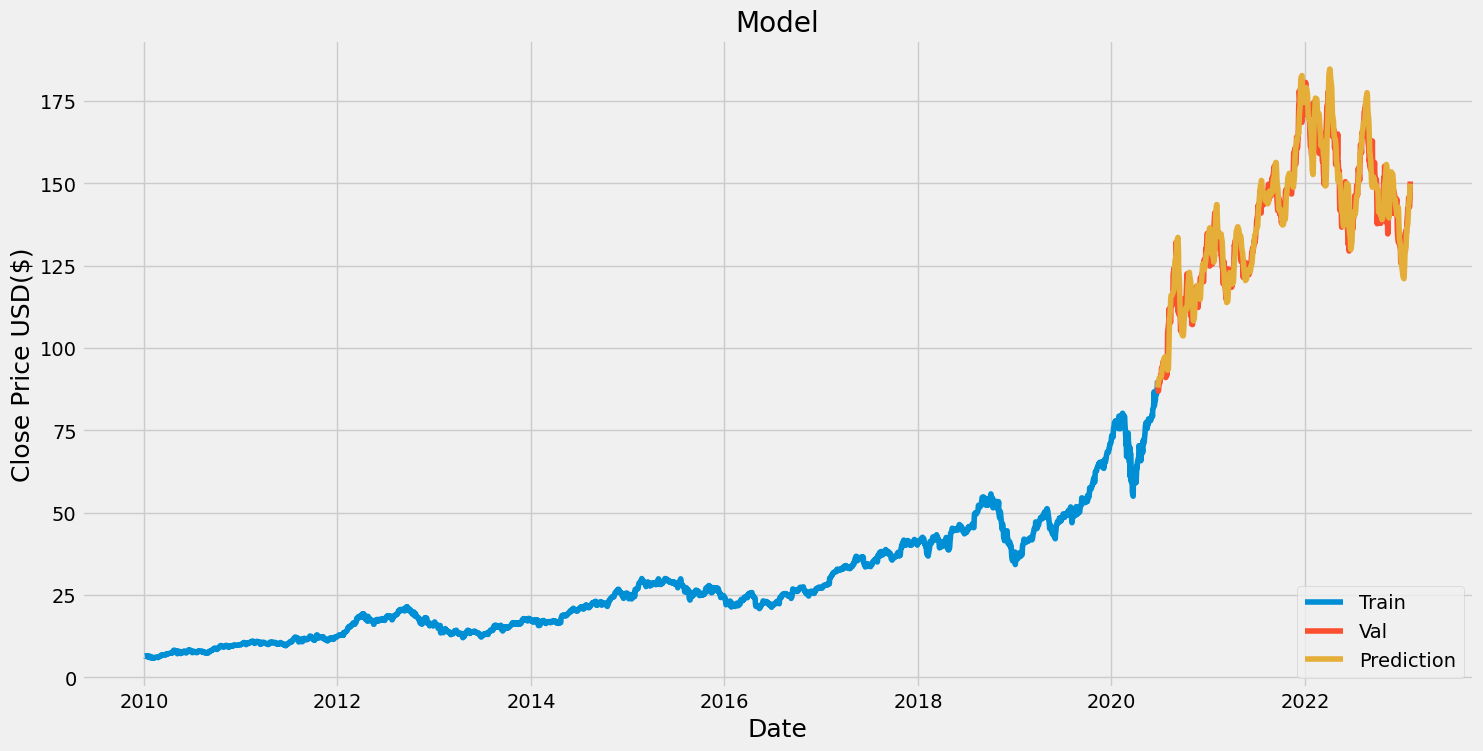

In [44]:
#Plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediction']=predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Prediction'],loc='lower right')
plt.show()

In [45]:
model.save('ga-cnn-lstm-final.h5')